# How to validate machine learned potentials

Joe D. Morrow 

## Introduction

## Contents

## License warning

In [7]:
import sys
sys.path.pop(1)

'/home/magnetite/vld/hert5155/QUIP_new/build/linux_x86_64_gfortran_openmp'

In [1]:
%%capture
# !conda create -n how-to-validate python=3.8
#!pip install -r requirements.txt # install some python packages

import numpy as np
from ase.io import read, write

In [2]:
%%capture
# compile lammps
!wget "https://github.com/lammps/lammps/archive/stable.zip"
!unzip -q stable.zip
!rm stable.zip
!mv lammps-stable lammps
!cd lammps && mkdir -p build && cd build && cmake ../cmake \
    -D PKG_ML-QUIP=yes -D DOWNLOAD_QUIP=yes -D USE_INTERNAL_LINALG=yes && make -j4

In [125]:
rundir = 'lammps_runs/run_nvt_test3'   # directory for the output files
data_file = 'structures/random_2.data'  # random initial structure - density is determined by this
restart_from = 'data'  # change to "continuation" to restart from previous run
random_seed = 2023        # random seed for lammps
melt_timesteps = 1000     # Timesteps in fs for melting
cool_timesteps = 1000     # Timesteps in fs for quenching (more = slower quench)
melt_temperature = 9000   # in Kelvin
final_temperature = 300   # in Kelvin

lammps_nvt_input = f'''
log {rundir}/log_nvt_C.dat append

units metal
atom_style atomic

if "{restart_from} == data" then "read_data {data_file}"
if "{restart_from} == data" then "reset_timestep 0"
if "{restart_from} == continuation" then "read_restart {rundir}/restart_nvt_C.*"

mass 1 12.011  # mass of carbon
pair_style quip
# carbon GAP potential from https://doi.org/10.1103/PhysRevB.95.094203
pair_coeff * * potentials/carbon.xml \"\" 6

neighbor 2.0 bin 
neigh_modify every 1 delay 0 check yes 

variable nAtoms equal atoms
group carbon type 1
timestep 0.001 
fix removeMomentum all momentum 1 linear 1 1 1 

compute T all temp 
fix TempAve all ave/time 100 1 100 c_T 

variable P equal press 
fix PressAve all ave/time 100 1 100 v_P 
variable v equal vol
fix vAve all ave/time 100 1 100 v_v
compute pe_at all pe/atom
compute PE all pe pair 
variable PE_Atom equal c_PE/v_nAtoms
fix PEAve_Atom all ave/time 100 1 100 v_PE_Atom

compute MSD all msd

thermo_style custom step cpu temp f_TempAve press f_PressAve f_PEAve_Atom vol f_vAve c_MSD[4] 
thermo_modify flush yes
thermo 100
dump traj all cfg 100 {rundir}/NVT/dump_nvt_C.*.cfg mass type xs ys zs id c_pe_at
dump_modify traj sort id element C pad 8
restart 100 {rundir}/restart_nvt_C.*

variable Nrun1 equal {melt_timesteps}
variable Nrun2 equal (${{Nrun1}}+{cool_timesteps})
if "{melt_timesteps} > 0 && $(step) == 0" then "velocity all create {melt_temperature} {random_seed}"

run 0
fix integrate all nvt temp {melt_temperature} {melt_temperature} 0.1
if "$(step) < ${{Nrun1}}" then "run ${{Nrun1}} upto"
unfix integrate

fix integrate all nvt temp {melt_temperature} {final_temperature} 0.1
if "$(step) < ${{Nrun2}}" then "run ${{Nrun2}} upto start ${{Nrun1}} stop ${{Nrun2}}"
unfix integrate

write_data {rundir}/out_data_quench_C
'''

with open("lammps_runs/nvt.in", "w") as f:
    f.write(lammps_nvt_input)

# Run lammps
Now we run an NVT simulation using the input file above  
and the carbon GAP potential from https://doi.org/10.1103/PhysRevB.95.094203

In [126]:
!mkdir -p ./lammps_runs/${rundir}/NVT
!export OMP_NUM_THREADS=1 && mpirun -np 1 lammps/build/lmp -in lammps_runs/nvt.in

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
LAMMPS (23 Jun 2022 - Update 2)
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (8.6177388 8.6177388 8.6177388)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  64 atoms
  read_data CPU = 0.001 seconds
64 atoms in group carbon
Neighbor list info ...
  update every 1 steps, delay 0 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 5.7
  ghost atom cutoff = 5.7
  binsize = 2.85, bins = 4 4 4
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair quip, perpetual
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocatio

# Structure analysis

In [79]:
from quippy.descriptors import Descriptor
import os
from os.path import join
import matplotlib.pyplot as plt

In [76]:
# read the structures
traj_dir = f'./{rundir}/NVT/'
atoms = [read(join(traj_dir, i)) for i in os.listdir(traj_dir)]

In [77]:
atoms

[Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),
 Atoms(symbols='C64', pbc=True, cell=[9.28318, 9.28318, 9.28318], c_pe_at=..., id=..., masses=...),


[Text(0.5, 0, 'Time (fs)'), Text(0, 0.5, 'Energy (eV)')]

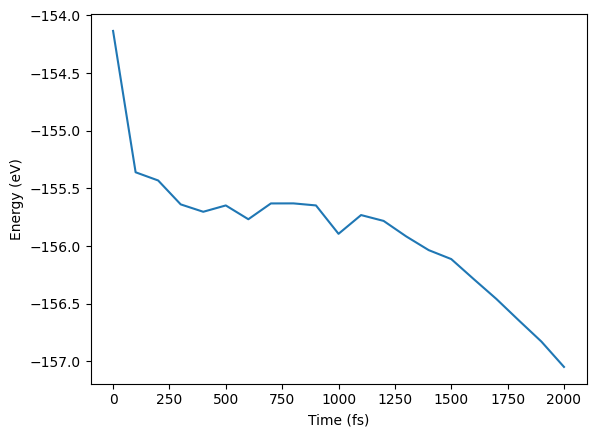

In [85]:
fig, axs = plt.subplots()
energies = [i.arrays['c_pe_at'].mean() for i in atoms]

axs.plot(np.arange(0, len(atoms)*100, 100), energies)
axs.set(xlabel='Time (fs)', ylabel='Energy (eV)')

## RDF analysis

In [86]:
from ase.geometry.analysis import Analysis

In [ ]:
geo_analysis = Analysis(atoms[0])

rdfs = geo_analysis.get_rdf(rmax=4, nbins=20, return_dists=True)[0]

In [120]:
rdfs

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.74685193, 1.38311165, 1.2843615 , 0.        , 0.        ,
        1.0441477 , 0.4894552 , 0.        , 1.29828463, 0.        ,
        0.77075278, 1.45820177, 0.69073625, 1.96596553, 2.49025101,
        1.48050002, 0.56400547, 1.61333248, 0.51333737, 0.98105243,
        0.46920242, 0.22461972, 1.07630974, 1.44533893, 0.99109517,
        1.71402079, 1.2818596 , 0.88106671, 1.52718913, 1.14462539,
        0.7883931 , 1.21717291, 0.73450354, 0.70960754, 1.37191236,
        0.39808072, 0.77048107, 1.2433724 , 1.08406821, 1.16746104,
        1.2452948 , 0.54914755, 0.74619627, 1.55264771, 0.80442102,
        0.87948314, 0.95006072, 1.2012433 , 0.62

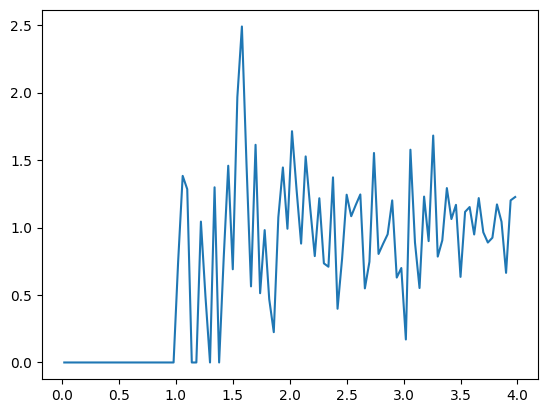

In [122]:
fig, axs = plt.subplots()
axs.plot(rdfs[1], rdfs[0])

# Generate some random structures

In [ ]:
at = read('random.data', format='lammps-data', style='atomic')
len(at)/at.get_volume()

In [34]:
from structure_utils import random_structure

at_10 = random_structure(64, 0.10, min_dist=1, types=['C'])
at_08 = random_structure(64, 0.08, min_dist=1, types=['C'])
at_12 = random_structure(64, 0.12, min_dist=1, types=['C'])

write('random_2.data', at_10, format='lammps-data', atom_style='atomic')
write('random_1.data', at_08, format='lammps-data', atom_style='atomic')
write('random_3.data', at_12, format='lammps-data', atom_style='atomic')

Percent: [##############################] 100.00% Done...
Complete
Percent: [##############################] 100.00% Done...
Complete
Percent: [##############################] 100.00% Done...
Complete


# Si trajectory analysis

In [ ]:
f